In [14]:
import tifffile as tiff
import numpy as np
from pathlib import Path
from cellpose import models
from skimage.measure import regionprops_table
import pandas as pd 
import matplotlib.pyplot as plt
from skimage.color import label2rgb
import openslide
import torch

In [2]:
dir_path = Path().resolve()
dir_path

PosixPath('/mnt/ldata/Sadegh/my_codes/nencki-image-segmentation/notebooks')

### Read Image Data

In [ ]:
# img = tiff.TiffFile(dir_path / "image/pHGG_1991_3149_Scan1-001.qptiff")
# series = img.series[0]
# print("Series shape:", series.shape)
# arr = series.asarray(out="memmap")
# print("Array shape:", arr.shape)

In [4]:
slide = openslide.OpenSlide(dir_path.parent / "image/pHGG_1991_3149_Scan1-001.qptiff")

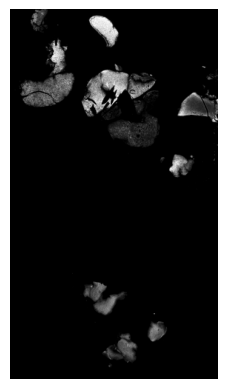

Dimensions: (36480, 64800)
Levels: 121


In [5]:
thumbnail = slide.get_thumbnail((500, 500))
plt.imshow(thumbnail)
plt.axis("off")
plt.show()
print("Dimensions:", slide.dimensions)
print("Levels:", slide.level_count)

In [6]:
# Display level dimensions in a table (Multiresolution levels)
df = pd.DataFrame(slide.level_dimensions, 
                  columns=["Width (px)", "Height (px)"])
df.index.name = "Level"
grouped = df.groupby(["Width (px)", "Height (px)"]).size().reset_index(name="Count")
grouped

,Width (px),Height (px),Count
0,2280,4050,30
1,4560,8100,30
2,9120,16200,30
3,18240,32400,30
4,36480,64800,1


In [7]:
w, h = slide.level_dimensions[1]
print(f"Level size: {w} x {h}")

Level size: 18240 x 32400


In [ ]:
# Select Level 1 DAPI
region = slide.read_region((0, 0), level=1, size=(w, h))

In [9]:
gray = region.convert("L")

In [10]:
arr = np.array(gray)
print("Array shape:", arr.shape)

Array shape: (32400, 18240)


In [ ]:
# def get_slide_series(slide):
#     series = []
#     for level in range(slide.level_count):
#         w, h = slide.level_dimensions[level]
#         region = slide.read_region((0, 0), level, (w, h))
#         arr = np.array(region)
#         series.append(arr)
#     return series

In [11]:
H = arr.shape[0]  
y_mid = H // 2   

# patient 3149
patient_3149 = arr[0:y_mid, :]

# patient 1991
patient_1991 = arr[y_mid:H, :]

### Apply Segmentation Model

In [15]:
device = torch.device("cuda:1")

In [16]:
# cyto for membrance / nuclei for nucleus   ---  GPU or CPU
model = models.CellposeModel(gpu=True, device=device, model_type="nuclei")

model_type argument is not used in v4.0.1+. Ignoring this argument...
100%|██████████| 1.15G/1.15G [02:39<00:00, 7.73MB/s]


In [ ]:
masks, flows, styles = model.eval(patient_3149, 
                                  diameter=20, 
                                  resample=False,          
                                  augment=False,        
                                  batch_size=1,        
                                  flow_threshold=0.4,    
                                  cellprob_threshold=0.0)

In [ ]:
overlay = label2rgb(masks, image=patient_3149, bg_label=0, alpha=0.3)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(patient_3149, cmap="gray"); axes[0].set_title("DAPI Tile"); axes[0].axis("off")
axes[1].imshow(masks, cmap="nipy_spectral"); axes[1].set_title("Segmentation Mask"); axes[1].axis("off")
axes[2].imshow(overlay); axes[2].set_title("Overlay (DAPI + Mask)"); axes[2].axis("off")
plt.show()

In [ ]:
# results = []
# visualized = False  
# tile_counter = 0    
# cell_counter = 0    

# for y in range(0, H, tile_size - overlap):
#     for x in range(0, W, tile_size - overlap):

#         y_end = min(y + tile_size, H)
#         x_end = min(x + tile_size, W)

#         tile = patient_3149[dapi_index, y:y_end, x:x_end]

#         masks, flows, styles = model.eval(tile, diameter=None)

#         tile_counter += 1 

#         if masks is None or (hasattr(masks, "max") and masks.max() == 0):
#             print(f"[Tile {tile_counter}] No cells detected at (x={x}, y={y})")
#             continue

#         if not visualized:
#             overlay = label2rgb(masks, image=tile, bg_label=0, alpha=0.3)
#             fig, axes = plt.subplots(1, 3, figsize=(15, 5))
#             axes[0].imshow(tile, cmap="gray"); axes[0].set_title("DAPI Tile"); axes[0].axis("off")
#             axes[1].imshow(masks, cmap="nipy_spectral"); axes[1].set_title("Segmentation Mask"); axes[1].axis("off")
#             axes[2].imshow(overlay); axes[2].set_title("Overlay (DAPI + Mask)"); axes[2].axis("off")
#             plt.show()
#             visualized = True

#         props = regionprops_table(
#             masks,
#             properties=("label", "centroid", "area", "perimeter")
#         )
#         df = pd.DataFrame(props)

#         df["x_global"] = df["centroid-1"] + x
#         df["y_global"] = df["centroid-0"] + y
#         df["tile_x0"] = x
#         df["tile_y0"] = y
#         df["tile_id"] = tile_counter

#         results.append(df)

#         cell_counter += len(df)
#         print(f"[Tile {tile_counter}] Found {len(df)} cells (Total so far: {cell_counter})")

# cells_df = pd.concat(results, ignore_index=True) if results else pd.DataFrame()
# print(f"\nProcessed {tile_counter} tiles. Total cells detected: {cell_counter}")
# print(cells_df.head())
